In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD
using JuMP
using COSMO
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [592]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    +/;# @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
               μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_8*[\]
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + ρ*Uc/cone_scale)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > 1e8
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [415]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n)
    bv = view(b, 1:n)

    n = length(x)-1
    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # n = n + 1
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

In [114]:
∇²projection([1.1 2 0], [4.1 5 6])

3×3 Matrix{Float64}:
  1.00908   -0.554993   0.227043
 -0.554993   0.305246  -0.124873
  0.227043  -0.124873   0.0

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.899759669898994
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.332808957455
  3    0.000e+00   3.85e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.184354202948654
  4    0.000e+00   4.04e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.769415514830488
  5    0.000e+00   5.76e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 2.2663427312107554
  6    0.000e+00   2.75e+07   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.5614987664730072
  7    0.000e+00   2.47e+08   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 0.5316092438866934
  8    0.000e+00   2.44e+09   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
convio 

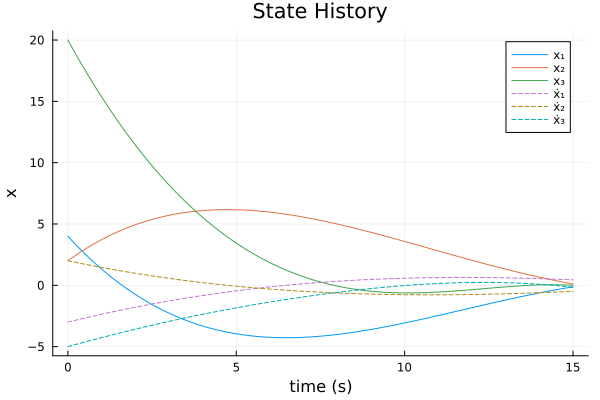

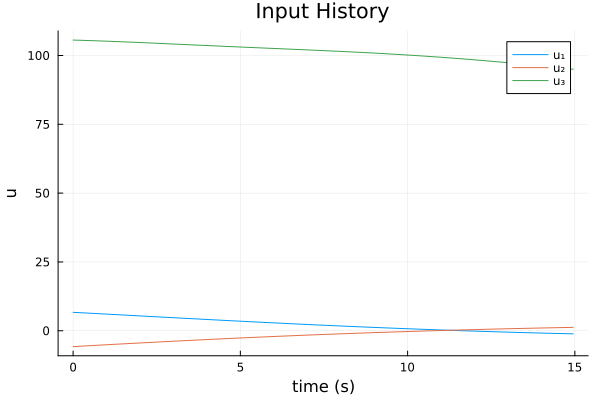

In [598]:
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 100  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [-mass * gravity for k = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation
- Scaling between conic constraints and other ones
- Solution polishing

In [537]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

-0.3427580357469697

-0.38432830183102595

-0.4258564136441674

-0.4673429191025047

-0.5087883632074828

-0.5501932881030438

-0.5915582331328562

-0.6328837348976588

-0.6741703273126181

-0.7154185416647358

-0.7566289066702225

-0.7978019485318342

-0.8389381909961333

-0.8800381554107108

-0.9211023607811395

-0.9621313238279612

-1.0031255590433314

-1.044085578747497

-1.0850118931451274

-1.1259050103812083

-1.1667654365967746

-1.2075936759842287

-1.2483902308423938

-1.2891556016310988

-1.3298902870254148

-1.370594783969378

-1.4112695877293477

-1.4519151919468243

-1.4925320886906714

-1.533120768508918

-1.5736817204798887

-1.6142154322627587

-1.6547223901474641

-1.6952030791039725

-1.7356579828308059

-1.776087583802898

-1.8164923633186776

-1.8568728015463645

-1.8972293775694542

-1.9375625694314182

-1.9778728541794006

-2.018160707907187

-2.0584266057971137

-2.098671022161076

-2.1388944304805255

-2.179097303445439

-2.2192801129922515

-2.259443330340667

-2.2995874260293823

-2.3397128699506435

-2.379820131383595

-2.419909679026391

-2.4599819810271226

-2.500037505013351

-2.540076718120355

-2.580100087018007

-2.62010807793619

-2.6601011566888237

-2.700079788696357

-2.740044439006696

-2.779995572314637

-2.819933652979545

-2.8598591450414714

-2.8997725122354643

-2.939674218004151

-2.979564725508478

-3.0194444976365515

-3.0593139970105456

-3.099173685991631

-3.139024026682822

-3.178865480929689

-3.218698510318892

-3.2585235761744737

-3.298341139551747

-3.3381516612288484

-3.3779556016957395

-3.4177534211406355

-3.457545579433786

-3.497332536108475

-3.537114750339123

-3.5768926809164983

-3.6166667862197563

-3.656437524185324

-3.6962053522724654

-3.7359707274253617

-3.7757341060316154

-3.815495943876992

-3.855256696096286

-3.8950168171200676

-3.934776760617231

-3.9745369794330623

-4.014297925522684

-4.054060049879619

-4.093823802459285

-4.133589632097128

-4.173357986421163

-4.213129311758638

-4.252904053036487

-4.292682653675245

-4.332465555476176

-4.372253198501072

-4.4120460209444765

-4.451844458997779

-4.491648946704824

-4.531459915808418

-4.571277795587316

-4.611103012682959

-4.65093599091548

-4.690777151088222

-4.7306269107799865

-4.770485684124333

-4.810353881574932

-4.85023190965616

-4.890120170697848

-4.930019062553022

-4.969928978297621

-5.009850305910682

-5.049783427933672

-5.0897287211074165

-5.129686555984929

-5.169657296518234

-5.209641299617221

-5.249638914678364

-5.289650483080719

-5.329676337646756

-5.36971680206493

-5.409772190270884

-5.449842805783738

-5.489928940993558

-5.530030876395747

-5.570148879767647

-5.610283205282045

-5.65043409255193

-5.690601765599947

-5.73078643174556

-5.770988280401943

-5.811207481773855

-5.851444185446677

-5.891698518855705

-5.931970585623449

-5.972260463751373

-6.012568203650593

-6.0528938259945395

-6.093237319374104

-6.133598637733552

-6.173977697562648

-6.2143743748172

-6.2547885015366

-6.295219862122682

-6.33566818923935

-6.376133159286825

-6.4166143873977335

-6.457111421894902

-6.4976237381415896

-6.538150731704949

-6.5786917107412854

-6.6192458874975895

-6.659812368807448

-6.700390145439657

-6.7409780801350205

-6.7815748941394

-6.822179152008424

-6.862789244420846

-6.903403368690653

-6.944019506612851

-6.984635399210385

-7.025248517868726

-7.065856031246368

-7.106454767229609

-7.147041169053659

-7.187611244532767

-7.228160507120434

-7.268683907247721

-7.309175752047347

-7.34962961114757

-7.390038205688747

-7.430393277046864

-7.470685430903751

-7.5109039512310725

-7.5510365773879204

-7.591069235780994

-7.6309857152860765

-7.670767272726508

-7.710392150948138

-7.749834987159349

-7.7890660828810425

-7.828050498648279

-7.866746925996179

-7.905106275638522

-7.943069903475501

-7.980567374659504

-8.017513640452322

-8.053805474427786

-8.089316988120833

-8.123894032057473

-8.157347308595394

-8.18944412177384

-8.21989894484621

-8.248363525397941

-8.274418243277129

-8.297568037656369

-8.31724832947801

-8.332848175453938

-8.343757344290331

-8.349438111959074

-8.349510094738863

-8.343822527352692

-8.332484949756138

-8.315842386279325

-8.294406564502044

-8.268771478010374

-8.239539811967793

-8.207273347153953

-8.17246754957643

-8.135544033485921

-8.096853640421806

-8.056684541797303

-8.01527187966059

-7.972807105870659

-7.929446221174676

-7.885316688499826

-7.840523071386146

-7.7951515594257605

-7.749273569644581

-7.702948601949107

-7.656226501905054

-7.609149256616371

-7.561752424203522

-7.51406627598642

-7.466116713130575

-7.417926005788675

-7.369513392058689

-7.320895565785165

-7.272087075830571

-7.223100654510182

-7.173947489078598

-7.124637447213257

-7.075179265159765

-7.025580705428723

-6.9758486895477985

-6.925989410285375

-6.876008426906086

-6.825910746341052

-6.775700892617202

-6.725382966460932

-6.674960696646745

-6.624437484384394

-6.573816441814433

-6.523100425499668

-6.472292065652626

-6.421393791716996

-6.370407854822558

-6.319336347550155

-6.268181221375894

-6.216944302107446

-6.165627303578159

-6.114231839825646

-6.062759435948736

-6.0112115378087925

-5.959589520718385

-5.907894697240379

-5.856128324203946

-5.8042916090295815

-5.7523857154434

-5.7004117686503415

-5.648370860027247

-5.596264051389021

-5.544092378874716

-5.491856856494594

-5.439558479374541

-5.387198226729822

-5.33477706459689

-5.282295948348541

-5.229755825015303

-5.177157635433717

-5.124502316240019

-5.071790801726532

-5.019024025576607

-4.966202922492931

-4.913328429733542

-4.860401488569292

-4.807423045676448

-4.754394054478244

-4.701315476449712

-4.648188282400817

-4.59501345375426

-4.541791983835601

-4.488524879195369

-4.4352131609853185

-4.381857866413209

-4.328460050304145

-4.275020786799141

-4.221541171225403

-4.168022322175107

-4.1144653838321075

-4.060871528585924

-4.007241959969789

-3.9535779159520397

-3.899880672596195

-3.8461515480832817

In [588]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)  # make this higher!
R = 1e-1*I(nu)
Qf = 10*I(nx) # change this!
θ_thrust_max = 5.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1e0

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-8,
    "eps_rel"=>1e-8,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    # pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    # vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    # noise_pos = randn(3)
    # noise_vel = randn(3)
    # Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, Xhist[i], A, B, f)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    X[1] .= Xhist[i]; Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 20,verbose = false,ρ = 100, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

1. COSMO gives better tracking results
2. Ours always need warm-start

In [579]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-0.34275803574675656

-2.7721792522186783

-3.183693482879894

-3.6223292610862767

-2.8549907754848585

-3.6075732252390305

-3.9924612846201644

-3.677437696954577

-2.722063956985104

-2.8866887354179536

-2.2353702810380875

-1.2212280664496102

-2.310182132139576

-3.595161226795847

-3.9799612178198025

-3.838025099209575

-4.113444476549922

-3.544795885095196

-3.529949863626168

-3.988373737007647

-3.4117413651151045

-2.539682496241854

-3.070756683414583

-3.5366209699520814

-3.1602626319169573

-2.8994671725657675

-2.7779419344918157

-2.804146660172794

-2.580281028196813

-2.982527590369891

-2.8122934992817603

-2.493301820340551

-2.3300439794437784

-1.93538033589477

-1.5795434404896112

-2.3274219973870363

-2.1382699014973996

-2.222630232774761

-1.8083713506318562

-2.206900766028851

-1.6672820156753225

-1.8014821378936734

-1.8626547863810794

-0.6623115321598867

-1.5742485122698788

-1.5154239146342299

-1.0470242593760126

-0.26876922366481715

-0.1658222717512121

-0.7018484775659619

-0.6088659198695225

-0.1852531837208069

280.4853292250721

-7.8422112453549095

-8.023211077953036

-7.958179448616908

-8.338943641513056

-8.357845375824661

-8.686538150095345

-8.624806781192346

-8.515723762495128

-8.699099096400408

-8.993459099211552

-9.126638546955878

-8.869972064379741

-9.063356872906265

-8.957107418677506

-8.927099379818033

-8.948593800585599

-8.835249170729927

-8.687467374281852

-8.249254992416324

-8.282018717321543

-8.3746590466126

-8.262816443376874

-8.313771628379845

-8.029010967642888

-7.795487288347591

-8.092919764300465

-8.211350173208945

-7.8446725508226685

-7.493199390646095

-6.968755122453871

-6.994884937994335

-6.80993604385996

-6.876622353808379

-6.908044695409522

-7.212345045533407

-6.836130011647582

-6.776945707164956

-6.854465571201885

-6.810087668513699

-6.652378668035867

-6.751939612683757

-6.599912868535424

-6.758158558308885

-6.659188522815407

-6.598330476260216

-6.6554597775878594

-6.40518148322781

-6.1355718178173895

-6.100926845298265

-6.087807270157857

-5.8108694570611545

-5.342546326374558

-5.002034704688217

-4.804841251866067

-4.965262937381703

-5.300555790115945

-5.12201738839256

-5.282467878801232

-5.3910472350004195

-5.3040914018487575

-5.041636606162265

-5.016160003758609

-5.084354190173443

-5.278892991330177

-5.303755667327637

-5.5966739568546

-5.59033736061512

-5.903044888990366

-5.993487988029868

-5.908820321324404

-6.059289368539455

-6.261541207366111

-5.978963939031574

-6.076142455496327

-6.055979690033004

-5.902994752785311

-5.693391252326876

-5.716729412324693

-5.703782330902834

-5.623723008107066

-5.578715125047118

-5.192226260183881

-4.9747797028429055

-5.095910542520732

-5.315467401676353

-5.287942762067966

-5.054021107629133

-5.118603508067773

-5.177966700252663

-4.847955814079723

-5.065646570801491

-5.052402743011372

-5.422920717104044

-5.325662710431839

-5.473094617403592

-5.392616589016593

-5.694388936740749

-5.8678369463853635

-5.9314375940599735

-5.968928927674407

-5.86925155606208

-5.688837607429184

-5.636654345038518

-5.611057641999959

-5.743375573018467

-5.622457559686339

-5.607487495635084

-5.748733525478055

-5.8118799664124685

-6.003058185647786

-5.811637785748145

-5.746192466804904

-5.9833205456020675

-5.985468346047684

-6.010168217536919

-5.6660626460681

-5.67716838955413

-5.71711566087688

-5.8548029673837

-6.08714390383156

-6.279446564985539

-6.188452273797074

-6.261628311528079

-6.190943815718509

-6.106784248332815

-5.987110500305498

-5.921223957128381

-6.132119552712787

-6.275457171092741

-6.559438851663242

-6.641876239079915

-6.6834237475553735

-6.688430711479053

-6.940293535958569

-6.963892134270827

-7.050645986160959

-7.112698637686506

-7.183392101541079

-6.997897345086797

-7.040132848275702

-7.393838683524196

-7.631785227279544

-7.7334857316086385

-7.6784085207816055

-7.770349610317193

-7.887517759710156

-8.146093689115471

-8.1953228093032

-8.326108035416793

-8.410489145392123

-8.271520562842095

-8.248580004615153

-8.257683963053557

-8.27898638450338

-8.21712967749848

-8.244056607588293

-8.1592138939649

-8.134834345434998

-8.181689415807638

-8.21826832597727

-8.191509527365042

-8.200586185167264

-8.206593259143306

-8.335792909014986

-8.37300432347613

-8.114870257401014

-8.030950195240427

-8.1500202335176

-8.150310239697372

-8.171061107516433

-8.145159776918735

-8.24147643275253

-8.18036643798014

-8.083868816246804

-7.938907624124721

-7.743416059426018

-7.737960513684685

-7.641762125603926

-7.655866022705817

-7.65115794811383

-7.609068075805933

-7.62906219609803

-7.646358892104333

-7.638482028304023

-7.605858284420054

-7.590535357960371

-7.480492267783145

-7.393462420699846

-7.286530354463199

-7.248330363268204

-7.2172760390462845

-7.064802569131574

-7.036322688562896

-6.996711545983122

-6.887198764009462

-6.862308603887609

-6.783761134630494

-6.724672774811804

-6.672005414376069

-6.619594477724062

-6.5758604071882765

-6.515816739741492

-6.5406230878598235

-6.511215097733235

-6.459601626485989

-6.383270347582476

-6.318090815347257

-6.255944390025407

-6.196932549513777

-6.124820485774242

-6.043273223654397

-5.9984107654726175

-5.908276195988318

-5.816627801946468

-5.750781371828992

-5.698338660874615

-5.635183433841355

-5.5436938816791335

-5.499015364691594

-5.448914807290498

-5.3880895425036215

-5.326343943182881

-5.267843741363867

-5.2066735161872995

-5.151318976128376

-5.096682561943561

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

traj_error = maximum(norm.(e_sim_m, Inf)) = 3.961031502797141e-11


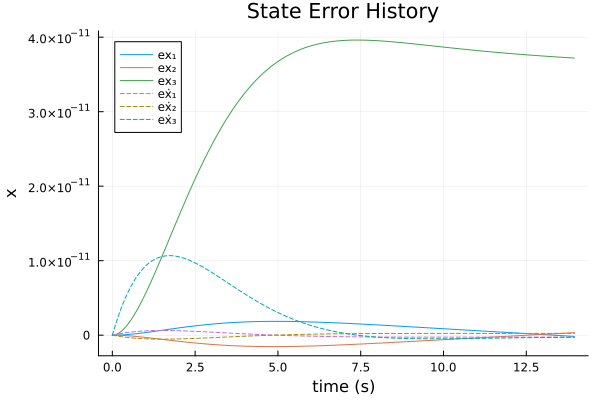

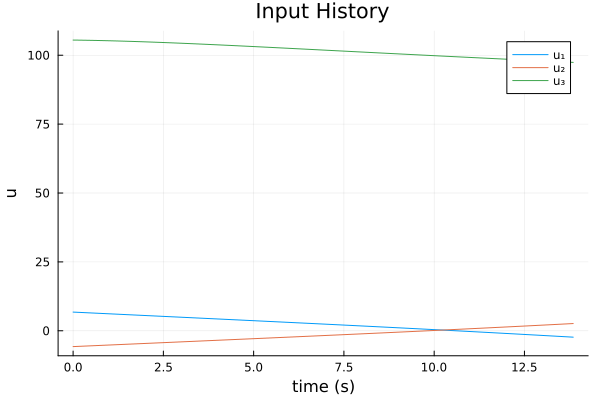

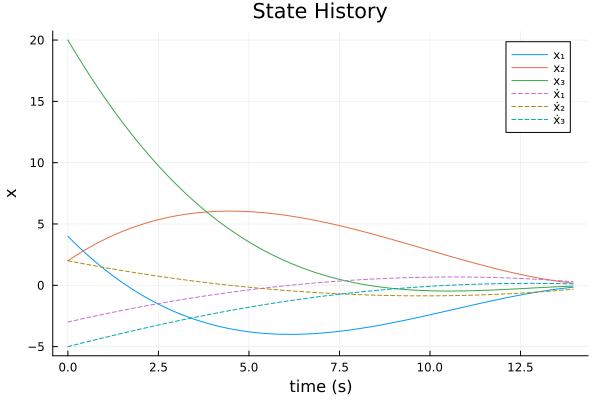

In [589]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))